# GameTheory-2-NormalForm

**Navigation** : [<< 1-Setup](GameTheory-1-Setup.ipynb) | [Index](README.md) | [3-Topology2x2 >>](GameTheory-3-Topology2x2.ipynb)

**Side tracks** : [2b-Lean-Definitions](GameTheory-2b-Lean-Definitions.ipynb)

## Jeux en Forme Normale

Ce notebook introduit la representation des jeux en **forme normale** (ou forme strategique), la facon standard de decrire les interactions strategiques.

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Definir** formellement un jeu en forme normale (joueurs, strategies, gains)
2. **Representer** un jeu par des matrices de gains et l'implementer en Python
3. **Identifier** les strategies dominantes et dominees
4. **Calculer** les meilleures reponses (best response) d'un joueur
5. **Appliquer** l'elimination iteree des strategies dominees (IESDS)
6. **Reconnaitre** les jeux classiques : Dilemme du Prisonnier, Stag Hunt, Chicken, etc.

### Concepts cles
- **Forme normale** : representation complete d'un jeu par ses matrices
- **Dominance** : une strategie toujours meilleure qu'une autre
- **Best response** : strategie optimale face a un choix adverse donne
- **IESDS** : simplification par elimination des strategies irrationnelles

### Duree estimee : 45 minutes

### Prerequis
- Notebook 1 (Setup) complete
- Notions de base en algebre lineaire (matrices)

In [1]:
# Imports
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

## 1. Definition formelle

### Jeu en forme normale

Un jeu en forme normale est defini par un triplet $G = (N, S, u)$ :

- $N = \{1, 2, ..., n\}$ : ensemble des **joueurs**
- $S = S_1 \times S_2 \times ... \times S_n$ : espace des **strategies**
  - $S_i$ : strategies disponibles pour le joueur $i$
- $u = (u_1, u_2, ..., u_n)$ : fonctions d'**utilite** (gains)
  - $u_i : S \to \mathbb{R}$ : gain du joueur $i$ pour chaque profil de strategies

### Cas particulier : jeux 2 joueurs

Pour 2 joueurs avec $m$ et $n$ strategies, on represente le jeu par deux matrices :
- $A \in \mathbb{R}^{m \times n}$ : gains du joueur Ligne (Row)
- $B \in \mathbb{R}^{m \times n}$ : gains du joueur Colonne (Column)

$A_{ij}$ = gain de Ligne quand Ligne joue $i$ et Colonne joue $j$

In [2]:
class NormalFormGame:
    """
    Representation d'un jeu en forme normale pour 2 joueurs.
    """
    
    def __init__(self, A: np.ndarray, B: np.ndarray, 
                 row_actions: List[str] = None,
                 col_actions: List[str] = None,
                 name: str = "Game"):
        """
        Args:
            A: Matrice des gains du joueur Ligne (m x n)
            B: Matrice des gains du joueur Colonne (m x n)
            row_actions: Noms des actions du joueur Ligne
            col_actions: Noms des actions du joueur Colonne
            name: Nom du jeu
        """
        self.A = np.array(A)
        self.B = np.array(B)
        self.name = name
        
        assert self.A.shape == self.B.shape, "Les matrices doivent avoir la meme forme"
        
        self.m, self.n = self.A.shape  # m actions Ligne, n actions Colonne
        
        self.row_actions = row_actions or [f"R{i}" for i in range(self.m)]
        self.col_actions = col_actions or [f"C{j}" for j in range(self.n)]
        
        # Creer le jeu Nashpy
        self.nash_game = nash.Game(self.A, self.B)
    
    def __repr__(self):
        return f"NormalFormGame('{self.name}', {self.m}x{self.n})"
    
    def payoff(self, i: int, j: int) -> Tuple[float, float]:
        """Retourne les gains pour le profil (i, j)."""
        return (self.A[i, j], self.B[i, j])
    
    def display(self):
        """Affiche le jeu sous forme de tableau."""
        print(f"\n{self.name}")
        print("=" * (len(self.name) + 10))
        
        # Header
        header = "          " + "  ".join(f"{c:>10}" for c in self.col_actions)
        print(header)
        print("-" * len(header))
        
        # Rows
        for i, row_action in enumerate(self.row_actions):
            row_str = f"{row_action:>8}  "
            for j in range(self.n):
                row_str += f"({self.A[i,j]:>3}, {self.B[i,j]:>3})  "
            print(row_str)

# Test
A = np.array([[3, 0], [5, 1]])
B = np.array([[3, 5], [0, 1]])
pd = NormalFormGame(A, B, ['Cooperer', 'Defaire'], ['Cooperer', 'Defaire'], 
                    name="Dilemme du Prisonnier")
pd.display()


Dilemme du Prisonnier
            Cooperer     Defaire
--------------------------------
Cooperer  (  3,   3)  (  0,   5)  
 Defaire  (  5,   0)  (  1,   1)  


## 2. Jeux classiques 2x2

Explorons plusieurs jeux classiques pour comprendre les differentes structures possibles.

In [3]:
# Collection de jeux classiques

def create_prisoners_dilemma():
    """Dilemme du Prisonnier - Probleme de cooperation."""
    A = np.array([[3, 0], [5, 1]])
    B = np.array([[3, 5], [0, 1]])
    return NormalFormGame(A, B, ['Cooperer', 'Defaire'], ['Cooperer', 'Defaire'],
                          "Dilemme du Prisonnier")

def create_stag_hunt():
    """Chasse au Cerf - Probleme de coordination avec risque."""
    A = np.array([[4, 0], [3, 3]])
    B = np.array([[4, 3], [0, 3]])
    return NormalFormGame(A, B, ['Cerf', 'Lievre'], ['Cerf', 'Lievre'],
                          "Chasse au Cerf (Stag Hunt)")

def create_battle_of_sexes():
    """Bataille des Sexes - Probleme de coordination pure."""
    A = np.array([[3, 0], [0, 2]])
    B = np.array([[2, 0], [0, 3]])
    return NormalFormGame(A, B, ['Opera', 'Football'], ['Opera', 'Football'],
                          "Bataille des Sexes")

def create_chicken():
    """Jeu du Poulet - Anti-coordination."""
    A = np.array([[0, -1], [1, -10]])
    B = np.array([[0, 1], [-1, -10]])
    return NormalFormGame(A, B, ['Devier', 'Continuer'], ['Devier', 'Continuer'],
                          "Jeu du Poulet (Chicken)")

def create_matching_pennies():
    """Matching Pennies - Jeu a somme nulle."""
    A = np.array([[1, -1], [-1, 1]])
    B = np.array([[-1, 1], [1, -1]])
    return NormalFormGame(A, B, ['Pile', 'Face'], ['Pile', 'Face'],
                          "Matching Pennies")

# Afficher tous les jeux
games = [
    create_prisoners_dilemma(),
    create_stag_hunt(),
    create_battle_of_sexes(),
    create_chicken(),
    create_matching_pennies()
]

for game in games:
    game.display()


Dilemme du Prisonnier
            Cooperer     Defaire
--------------------------------
Cooperer  (  3,   3)  (  0,   5)  
 Defaire  (  5,   0)  (  1,   1)  

Chasse au Cerf (Stag Hunt)
                Cerf      Lievre
--------------------------------
    Cerf  (  4,   4)  (  0,   3)  
  Lievre  (  3,   0)  (  3,   3)  

Bataille des Sexes
               Opera    Football
--------------------------------
   Opera  (  3,   2)  (  0,   0)  
Football  (  0,   0)  (  2,   3)  

Jeu du Poulet (Chicken)
              Devier   Continuer
--------------------------------
  Devier  (  0,   0)  ( -1,   1)  
Continuer  (  1,  -1)  (-10, -10)  

Matching Pennies
                Pile        Face
--------------------------------
    Pile  (  1,  -1)  ( -1,   1)  
    Face  ( -1,   1)  (  1,  -1)  


## 3. Dominance

### Definitions

Une strategie $s_i$ **domine strictement** une strategie $s_i'$ si :
$$u_i(s_i, s_{-i}) > u_i(s_i', s_{-i}) \quad \forall s_{-i} \in S_{-i}$$

Une strategie $s_i$ **domine faiblement** une strategie $s_i'$ si :
$$u_i(s_i, s_{-i}) \geq u_i(s_i', s_{-i}) \quad \forall s_{-i}$$
avec au moins une inegalite stricte.

Une strategie est **dominante** si elle domine toutes les autres strategies.

In [4]:
def is_strictly_dominated(game: NormalFormGame, player: int, strategy: int) -> Tuple[bool, Optional[int]]:
    """
    Verifie si une strategie est strictement dominee.
    
    Args:
        game: Le jeu
        player: 0 pour Ligne, 1 pour Colonne
        strategy: Index de la strategie a verifier
    
    Returns:
        (is_dominated, dominating_strategy)
    """
    if player == 0:  # Joueur Ligne
        payoffs = game.A
        n_strategies = game.m
    else:  # Joueur Colonne
        payoffs = game.B.T  # Transposer pour traiter uniformement
        n_strategies = game.n
    
    for other in range(n_strategies):
        if other == strategy:
            continue
        
        # Verifier si 'other' domine strictement 'strategy'
        if player == 0:
            dominates = all(game.A[other, j] > game.A[strategy, j] for j in range(game.n))
        else:
            dominates = all(game.B[i, other] > game.B[i, strategy] for i in range(game.m))
        
        if dominates:
            return True, other
    
    return False, None

def find_dominant_strategy(game: NormalFormGame, player: int) -> Optional[int]:
    """
    Trouve une strategie dominante pour un joueur.
    
    Returns:
        Index de la strategie dominante, ou None si aucune.
    """
    n_strategies = game.m if player == 0 else game.n
    
    for s in range(n_strategies):
        is_dominant = True
        for other in range(n_strategies):
            if other == s:
                continue
            
            if player == 0:
                dominates = all(game.A[s, j] >= game.A[other, j] for j in range(game.n))
            else:
                dominates = all(game.B[i, s] >= game.B[i, other] for i in range(game.m))
            
            if not dominates:
                is_dominant = False
                break
        
        if is_dominant:
            return s
    
    return None

# Analyser le Dilemme du Prisonnier
pd = create_prisoners_dilemma()
pd.display()

print("\nAnalyse de dominance:")
print("-" * 40)

# Joueur Ligne
dom_row = find_dominant_strategy(pd, 0)
if dom_row is not None:
    print(f"Joueur Ligne: '{pd.row_actions[dom_row]}' est dominante")
else:
    print("Joueur Ligne: pas de strategie dominante")

# Joueur Colonne
dom_col = find_dominant_strategy(pd, 1)
if dom_col is not None:
    print(f"Joueur Colonne: '{pd.col_actions[dom_col]}' est dominante")


Dilemme du Prisonnier
            Cooperer     Defaire
--------------------------------
Cooperer  (  3,   3)  (  0,   5)  
 Defaire  (  5,   0)  (  1,   1)  

Analyse de dominance:
----------------------------------------
Joueur Ligne: 'Defaire' est dominante
Joueur Colonne: 'Defaire' est dominante


In [5]:
# Analyser tous les jeux classiques
print("Analyse de dominance pour les jeux classiques")
print("=" * 50)

for game in games:
    print(f"\n{game.name}:")
    
    dom_row = find_dominant_strategy(game, 0)
    dom_col = find_dominant_strategy(game, 1)
    
    if dom_row is not None:
        print(f"  Ligne: '{game.row_actions[dom_row]}' dominante")
    else:
        print(f"  Ligne: aucune strategie dominante")
    
    if dom_col is not None:
        print(f"  Colonne: '{game.col_actions[dom_col]}' dominante")
    else:
        print(f"  Colonne: aucune strategie dominante")

Analyse de dominance pour les jeux classiques

Dilemme du Prisonnier:
  Ligne: 'Defaire' dominante
  Colonne: 'Defaire' dominante

Chasse au Cerf (Stag Hunt):
  Ligne: aucune strategie dominante
  Colonne: aucune strategie dominante

Bataille des Sexes:
  Ligne: aucune strategie dominante
  Colonne: aucune strategie dominante

Jeu du Poulet (Chicken):
  Ligne: aucune strategie dominante
  Colonne: aucune strategie dominante

Matching Pennies:
  Ligne: aucune strategie dominante
  Colonne: aucune strategie dominante


### Observation

Seul le **Dilemme du Prisonnier** a une strategie dominante pour les deux joueurs ("Defaire").

Les autres jeux necessitent des concepts plus raffines pour predire le comportement.

## 4. Meilleure Reponse (Best Response)

### Definition

La **meilleure reponse** du joueur $i$ a la strategie $s_{-i}$ des autres joueurs est :
$$BR_i(s_{-i}) = \arg\max_{s_i \in S_i} u_i(s_i, s_{-i})$$

Pour les jeux 2x2 :
- $BR_{Ligne}(j)$ = strategie de Ligne maximisant son gain quand Colonne joue $j$
- $BR_{Col}(i)$ = strategie de Colonne maximisant son gain quand Ligne joue $i$

In [6]:
def best_response_row(game: NormalFormGame, col_strategy: int) -> List[int]:
    """
    Meilleure(s) reponse(s) du joueur Ligne a la strategie de Colonne.
    
    Returns:
        Liste des indices des meilleures reponses.
    """
    payoffs = game.A[:, col_strategy]
    max_payoff = np.max(payoffs)
    return [i for i in range(game.m) if payoffs[i] == max_payoff]

def best_response_col(game: NormalFormGame, row_strategy: int) -> List[int]:
    """
    Meilleure(s) reponse(s) du joueur Colonne a la strategie de Ligne.
    """
    payoffs = game.B[row_strategy, :]
    max_payoff = np.max(payoffs)
    return [j for j in range(game.n) if payoffs[j] == max_payoff]

def analyze_best_responses(game: NormalFormGame):
    """
    Analyse complete des meilleures reponses.
    """
    print(f"\nMeilleures reponses - {game.name}")
    print("=" * 50)
    
    print("\nJoueur Ligne (reponses aux actions de Colonne):")
    for j in range(game.n):
        br = best_response_row(game, j)
        br_names = [game.row_actions[i] for i in br]
        print(f"  Si Colonne joue '{game.col_actions[j]}' -> BR = {br_names}")
    
    print("\nJoueur Colonne (reponses aux actions de Ligne):")
    for i in range(game.m):
        br = best_response_col(game, i)
        br_names = [game.col_actions[j] for j in br]
        print(f"  Si Ligne joue '{game.row_actions[i]}' -> BR = {br_names}")

# Analyser le Dilemme du Prisonnier
pd = create_prisoners_dilemma()
analyze_best_responses(pd)


Meilleures reponses - Dilemme du Prisonnier

Joueur Ligne (reponses aux actions de Colonne):
  Si Colonne joue 'Cooperer' -> BR = ['Defaire']
  Si Colonne joue 'Defaire' -> BR = ['Defaire']

Joueur Colonne (reponses aux actions de Ligne):
  Si Ligne joue 'Cooperer' -> BR = ['Defaire']
  Si Ligne joue 'Defaire' -> BR = ['Defaire']


In [7]:
# Analyser la Bataille des Sexes
bos = create_battle_of_sexes()
bos.display()
analyze_best_responses(bos)


Bataille des Sexes
               Opera    Football
--------------------------------
   Opera  (  3,   2)  (  0,   0)  
Football  (  0,   0)  (  2,   3)  

Meilleures reponses - Bataille des Sexes

Joueur Ligne (reponses aux actions de Colonne):
  Si Colonne joue 'Opera' -> BR = ['Opera']
  Si Colonne joue 'Football' -> BR = ['Football']

Joueur Colonne (reponses aux actions de Ligne):
  Si Ligne joue 'Opera' -> BR = ['Opera']
  Si Ligne joue 'Football' -> BR = ['Football']


### Relation avec l'equilibre de Nash

Un profil de strategies $(s_i^*, s_{-i}^*)$ est un **equilibre de Nash** si et seulement si :
$$s_i^* \in BR_i(s_{-i}^*) \quad \forall i \in N$$

Autrement dit, chaque joueur joue une meilleure reponse a ce que jouent les autres.

In [8]:
def find_pure_nash_equilibria(game: NormalFormGame) -> List[Tuple[int, int]]:
    """
    Trouve tous les equilibres de Nash en strategies pures.
    
    Un profil (i, j) est un Nash si:
    - i est meilleure reponse a j pour Ligne
    - j est meilleure reponse a i pour Colonne
    """
    equilibria = []
    
    for i in range(game.m):
        for j in range(game.n):
            # i est-il meilleure reponse a j ?
            br_row = best_response_row(game, j)
            # j est-il meilleure reponse a i ?
            br_col = best_response_col(game, i)
            
            if i in br_row and j in br_col:
                equilibria.append((i, j))
    
    return equilibria

# Trouver les equilibres Nash pour tous les jeux
print("Equilibres de Nash en strategies pures")
print("=" * 50)

for game in games:
    eq = find_pure_nash_equilibria(game)
    print(f"\n{game.name}:")
    
    if eq:
        for (i, j) in eq:
            payoff = game.payoff(i, j)
            print(f"  ({game.row_actions[i]}, {game.col_actions[j]}) -> gains {payoff}")
    else:
        print("  Aucun equilibre en strategies pures")

Equilibres de Nash en strategies pures

Dilemme du Prisonnier:
  (Defaire, Defaire) -> gains (np.int64(1), np.int64(1))

Chasse au Cerf (Stag Hunt):
  (Cerf, Cerf) -> gains (np.int64(4), np.int64(4))
  (Lievre, Lievre) -> gains (np.int64(3), np.int64(3))

Bataille des Sexes:
  (Opera, Opera) -> gains (np.int64(3), np.int64(2))
  (Football, Football) -> gains (np.int64(2), np.int64(3))

Jeu du Poulet (Chicken):
  (Devier, Continuer) -> gains (np.int64(-1), np.int64(1))
  (Continuer, Devier) -> gains (np.int64(1), np.int64(-1))

Matching Pennies:
  Aucun equilibre en strategies pures


## 5. Visualisation des meilleures reponses

Visualisons les meilleures reponses dans la matrice de gains.

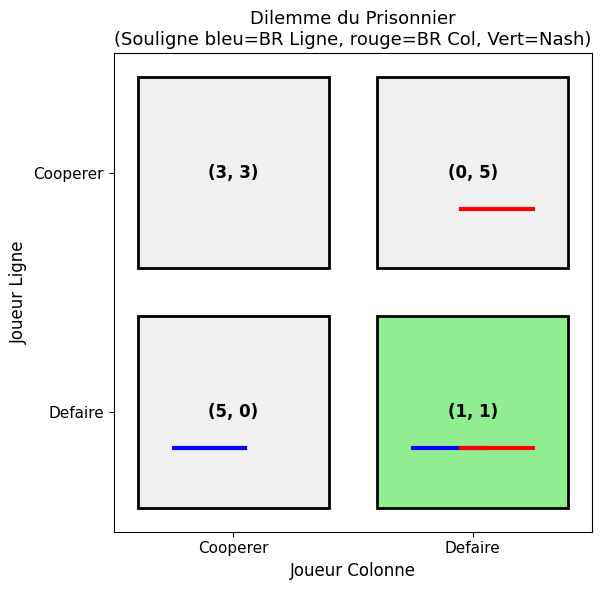

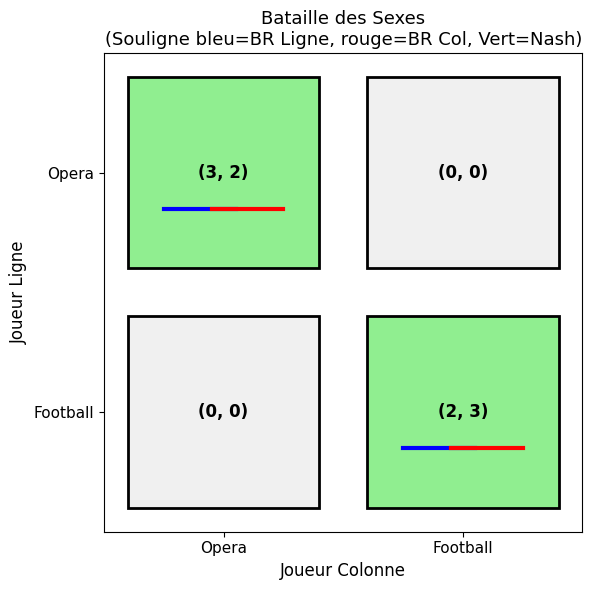

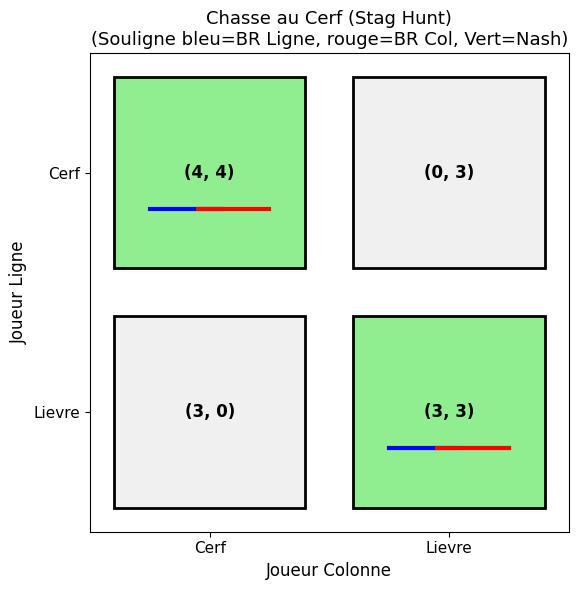

In [9]:
def plot_game_with_br(game: NormalFormGame):
    """
    Visualise un jeu avec les meilleures reponses marquees.
    
    - Cercle autour du gain de Ligne si meilleure reponse
    - Carre autour du gain de Colonne si meilleure reponse
    - Fond vert si equilibre de Nash
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Trouver les meilleures reponses
    br_row_map = {j: best_response_row(game, j) for j in range(game.n)}
    br_col_map = {i: best_response_col(game, i) for i in range(game.m)}
    
    # Equilibres Nash
    nash_eq = find_pure_nash_equilibria(game)
    
    for i in range(game.m):
        for j in range(game.n):
            # Position de la cellule
            x, y = j, game.m - 1 - i
            
            # Couleur de fond
            if (i, j) in nash_eq:
                color = '#90EE90'  # Vert clair pour Nash
            else:
                color = '#F0F0F0'  # Gris clair
            
            rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8,
                                   facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            
            # Gains
            payoff_text = f"({game.A[i,j]}, {game.B[i,j]})"
            ax.text(x, y, payoff_text, ha='center', va='center', 
                   fontsize=12, fontweight='bold')
            
            # Marquer meilleure reponse Ligne (souligner le premier nombre)
            if i in br_row_map[j]:
                ax.plot([x-0.25, x+0.05], [y-0.15, y-0.15], 'b-', linewidth=3)
            
            # Marquer meilleure reponse Colonne (souligner le second nombre)
            if j in br_col_map[i]:
                ax.plot([x-0.05, x+0.25], [y-0.15, y-0.15], 'r-', linewidth=3)
    
    # Configuration des axes
    ax.set_xlim(-0.5, game.n - 0.5)
    ax.set_ylim(-0.5, game.m - 0.5)
    
    ax.set_xticks(range(game.n))
    ax.set_yticks(range(game.m))
    ax.set_xticklabels(game.col_actions, fontsize=11)
    ax.set_yticklabels(game.row_actions[::-1], fontsize=11)
    
    ax.set_xlabel('Joueur Colonne', fontsize=12)
    ax.set_ylabel('Joueur Ligne', fontsize=12)
    ax.set_title(f"{game.name}\n(Souligne bleu=BR Ligne, rouge=BR Col, Vert=Nash)", 
                fontsize=13)
    
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Visualiser plusieurs jeux
plot_game_with_br(create_prisoners_dilemma())
plot_game_with_br(create_battle_of_sexes())
plot_game_with_br(create_stag_hunt())

## 6. Elimination iteree des strategies dominees (IESDS)

L'**Iterated Elimination of Strictly Dominated Strategies** permet de simplifier un jeu en eliminant successivement les strategies qu'aucun joueur rationnel ne jouerait.

In [10]:
def eliminate_dominated_strategies(A: np.ndarray, B: np.ndarray, 
                                    row_names: List[str], col_names: List[str],
                                    verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, List[str], List[str]]:
    """
    Elimination iteree des strategies strictement dominees.
    
    Returns:
        Matrices et noms reduits.
    """
    A = A.copy()
    B = B.copy()
    row_names = list(row_names)
    col_names = list(col_names)
    
    iteration = 0
    changed = True
    
    while changed:
        changed = False
        iteration += 1
        
        # Eliminer strategies dominees pour Ligne
        m = A.shape[0]
        to_remove = []
        
        for i in range(m):
            for other in range(m):
                if other == i or other in to_remove:
                    continue
                # 'other' domine strictement 'i' ?
                if all(A[other, j] > A[i, j] for j in range(A.shape[1])):
                    to_remove.append(i)
                    if verbose:
                        print(f"Iteration {iteration}: Ligne '{row_names[i]}' dominee par '{row_names[other]}'")
                    break
        
        if to_remove:
            changed = True
            keep = [i for i in range(m) if i not in to_remove]
            A = A[keep, :]
            B = B[keep, :]
            row_names = [row_names[i] for i in keep]
        
        # Eliminer strategies dominees pour Colonne
        n = A.shape[1]
        to_remove = []
        
        for j in range(n):
            for other in range(n):
                if other == j or other in to_remove:
                    continue
                # 'other' domine strictement 'j' ?
                if all(B[i, other] > B[i, j] for i in range(A.shape[0])):
                    to_remove.append(j)
                    if verbose:
                        print(f"Iteration {iteration}: Colonne '{col_names[j]}' dominee par '{col_names[other]}'")
                    break
        
        if to_remove:
            changed = True
            keep = [j for j in range(n) if j not in to_remove]
            A = A[:, keep]
            B = B[:, keep]
            col_names = [col_names[j] for j in keep]
    
    return A, B, row_names, col_names

# Exemple avec un jeu 3x3
print("Exemple d'IESDS sur un jeu 3x3")
print("=" * 50)

A = np.array([
    [4, 3, 2],
    [5, 4, 3],  # Domine la premiere ligne
    [3, 2, 1]
])
B = np.array([
    [1, 2, 1],
    [2, 3, 2],  # La colonne du milieu domine les autres
    [1, 2, 1]
])

game_3x3 = NormalFormGame(A, B, ['R1', 'R2', 'R3'], ['C1', 'C2', 'C3'], "Jeu 3x3")
game_3x3.display()

print("\nElimination iteree:")
print("-" * 40)
A_red, B_red, row_red, col_red = eliminate_dominated_strategies(
    A, B, ['R1', 'R2', 'R3'], ['C1', 'C2', 'C3'])

print(f"\nJeu reduit: {len(row_red)}x{len(col_red)}")
print(f"Strategies restantes: Ligne={row_red}, Colonne={col_red}")
print(f"Issue predite: ({row_red[0]}, {col_red[0]}) avec gains ({A_red[0,0]}, {B_red[0,0]})")

Exemple d'IESDS sur un jeu 3x3

Jeu 3x3
                  C1          C2          C3
--------------------------------------------
      R1  (  4,   1)  (  3,   2)  (  2,   1)  
      R2  (  5,   2)  (  4,   3)  (  3,   2)  
      R3  (  3,   1)  (  2,   2)  (  1,   1)  

Elimination iteree:
----------------------------------------
Iteration 1: Ligne 'R1' dominee par 'R2'
Iteration 1: Ligne 'R3' dominee par 'R2'
Iteration 1: Colonne 'C1' dominee par 'C2'
Iteration 1: Colonne 'C3' dominee par 'C2'

Jeu reduit: 1x1
Strategies restantes: Ligne=['R2'], Colonne=['C2']
Issue predite: (R2, C2) avec gains (4, 3)


## 7. Jeux a plus de 2 actions : Pierre-Feuille-Ciseaux

Le jeu **Pierre-Feuille-Ciseaux** (Rock-Paper-Scissors) est un jeu a somme nulle classique.

In [11]:
# Pierre-Feuille-Ciseaux
# Pierre bat Ciseaux, Ciseaux bat Feuille, Feuille bat Pierre

A_rps = np.array([
    [0, -1, 1],   # Pierre: nul vs P, perd vs F, gagne vs C
    [1, 0, -1],   # Feuille: gagne vs P, nul vs F, perd vs C
    [-1, 1, 0]    # Ciseaux: perd vs P, gagne vs F, nul vs C
])

B_rps = -A_rps  # Jeu a somme nulle

rps = NormalFormGame(A_rps, B_rps, 
                     ['Pierre', 'Feuille', 'Ciseaux'],
                     ['Pierre', 'Feuille', 'Ciseaux'],
                     "Pierre-Feuille-Ciseaux")
rps.display()

# Equilibres purs ?
eq = find_pure_nash_equilibria(rps)
print(f"\nEquilibres de Nash purs: {eq if eq else 'Aucun'}")

# Meilleures reponses
analyze_best_responses(rps)


Pierre-Feuille-Ciseaux
              Pierre     Feuille     Ciseaux
--------------------------------------------
  Pierre  (  0,   0)  ( -1,   1)  (  1,  -1)  
 Feuille  (  1,  -1)  (  0,   0)  ( -1,   1)  
 Ciseaux  ( -1,   1)  (  1,  -1)  (  0,   0)  

Equilibres de Nash purs: Aucun

Meilleures reponses - Pierre-Feuille-Ciseaux

Joueur Ligne (reponses aux actions de Colonne):
  Si Colonne joue 'Pierre' -> BR = ['Feuille']
  Si Colonne joue 'Feuille' -> BR = ['Ciseaux']
  Si Colonne joue 'Ciseaux' -> BR = ['Pierre']

Joueur Colonne (reponses aux actions de Ligne):
  Si Ligne joue 'Pierre' -> BR = ['Feuille']
  Si Ligne joue 'Feuille' -> BR = ['Ciseaux']
  Si Ligne joue 'Ciseaux' -> BR = ['Pierre']


In [12]:
# Equilibres mixtes avec Nashpy
print("\nEquilibres de Nash (purs et mixtes):")
print("-" * 40)

for eq in rps.nash_game.support_enumeration():
    sigma_row, sigma_col = eq
    print(f"\nJoueur Ligne:   {np.round(sigma_row, 3)}")
    print(f"Joueur Colonne: {np.round(sigma_col, 3)}")
    
    # Verifier si mixte
    if np.sum(sigma_row > 0.01) > 1:  # Plus d'une strategie jouee
        print("-> Equilibre en strategies mixtes")
        # Gain espere (devrait etre 0 dans un jeu symetrique a somme nulle)
        exp_payoff = sigma_row @ A_rps @ sigma_col
        print(f"   Gain espere: {exp_payoff:.3f}")


Equilibres de Nash (purs et mixtes):
----------------------------------------

Joueur Ligne:   [0.333 0.333 0.333]
Joueur Colonne: [0.333 0.333 0.333]
-> Equilibre en strategies mixtes
   Gain espere: 0.000


### Interpretation

L'unique equilibre de Nash de RPS est en strategies **mixtes** : chaque joueur joue chaque action avec probabilite 1/3.

C'est intuitif : si un joueur favorisait une action, l'adversaire pourrait l'exploiter.

## 8. Resume

### Concepts cles

| Concept | Definition |
|---------|------------|
| **Forme normale** | Representation par matrices de gains |
| **Strategie dominante** | Toujours optimale, independamment des autres |
| **Strategie dominee** | Jamais optimale, toujours battue |
| **Meilleure reponse** | Strategie optimale etant donne les choix des autres |
| **Equilibre de Nash** | Profil ou chacun joue une meilleure reponse |
| **IESDS** | Simplification par elimination des strategies irrationnelles |

### Types de jeux rencontres

| Jeu | Caracteristique | Equilibres Nash |
|----|-----------------|------------------|
| Dilemme du Prisonnier | Strategie dominante | 1 pur (Defaire, Defaire) |
| Stag Hunt | Coordination avec risque | 2 purs + 1 mixte |
| Bataille des Sexes | Coordination pure | 2 purs + 1 mixte |
| Chicken | Anti-coordination | 2 purs + 1 mixte |
| Matching Pennies | Somme nulle | 1 mixte |
| RPS | Somme nulle symetrique | 1 mixte |

## 9. Exercices

### Exercice 1
Analysez le jeu suivant (variante du Dilemme du Prisonnier avec 3 actions) :

| | Cooperer | Defaire | Punir |
|--|----------|---------|-------|
| **Cooperer** | (3,3) | (0,5) | (0,2) |
| **Defaire** | (5,0) | (1,1) | (0,0) |
| **Punir** | (2,0) | (0,0) | (0,0) |

### Exercice 2
Trouvez les equilibres de Nash du jeu de Matching Pennies generalise (3 faces).

### Exercice 3
Implementez l'elimination iteree des strategies **faiblement** dominees (IEWDS).

In [13]:
# Espace pour les exercices

# Exercice 1
# A_ex1 = np.array([...])
# B_ex1 = np.array([...])
# game_ex1 = NormalFormGame(...)

---

**Notebook precedent**: [GameTheory-1-Setup](GameTheory-1-Setup.ipynb)  
**Notebook suivant**: [GameTheory-3-Topology2x2](GameTheory-3-Topology2x2.ipynb)